In [1]:
%reload_ext autoreload
%autoreload

import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import topocalib
from topocalib.layout import generate_layout, show_layout
from topocalib.model_cv import generate_projections
from topocalib.model import get_rotation, get_angles
from topocalib.optimizer import optimize
from topocalib.visualise import show_correlation_matrix, show_residuals, wrap

$$
R_{c1}^{w1} R_{c1}^{c2} (R_{c2}^{w2})^T R_{w1}^{w2} = 0 \\
P_i^{w1} = R_{w2}^{w1} P_i^{w2} + T_{w1}^{w2}
$$

where unknowns are $ R_{c1}^{w1} $, $ R_{c2}^{w2} $ and $ R_{w2}^{w1} $

---

Be careful about initial guess!

In [2]:
%autoreload
Rs = [1, 0, 0]
Rso = get_angles(get_rotation(Rs))
print(Rs, Rso)

[1, 0, 0] [ 1.  0. -0.]


In [3]:
%matplotlib widget

Ts1, Rs1, X_ws1 = generate_layout(slope=np.pi/11, step=1.1, nplains=1, distance=4, plainsize=(6, 6), planetransl=[-1, -3, 0.5])
_, _, X_ws2 = generate_layout(nplains=1, plainsize=(6, 6), planetransl=[-1, -2, - 3.83 * 2])

"""
for i in range(len(X_ws1)):
    for j in range(len(X_ws1[i])):
        X_ws1[i][j] = (get_rotation([0.2, 0, 0]) * np.matrix(X_ws1[i][j]).T).A1
        #X_ws2[i][j] = np.random.normal(scale=0.1)
"""

X_cs1 = generate_projections(X_ws1, Ts1, Rs1)


Ts1[:, 2] += np.random.normal(scale=0.5, size=(len(Ts1), 1))

"""
for i in range(len(X_ws1)):
    for j in range(len(X_ws1[i])):
        X_ws1[i][j, 2] += np.random.normal(scale=0.1)
        X_ws2[i][j, 2] += np.random.normal(scale=0.1)
"""

ax = show_layout(Ts1, Rs1, X_ws1)

Rs2 = []
Ts2 = Ts1.copy()

R12 = [np.pi + np.pi / 5.5, 0, 0]

for R in Rs1:    
    R_add = get_rotation(R12)
    R_mat = get_rotation(np.matrix(R).A1) * R_add
    R_new = get_angles(R_mat)
    Rs2.append(np.matrix(R_new))
    
X_cs2 = generate_projections(X_ws2, Ts2, Rs2)
print(Ts2[0], Ts1[0])
#Ts2[:, 2] += 0.5


show_layout(Ts2, Rs2, X_ws2, ax=ax)

print(f'R12 = {R12}')

FigureCanvasNbAgg()

[[-1.12693023  0.          4.31479889]] [[-1.12693023  0.          4.31479889]]
R12 = [3.7127913178788465, 0, 0]


In [4]:
print(Ts1)
print(Ts2)

[[-1.12693023  0.          4.31479889]
 [-0.51117118  1.00432851  3.89300912]
 [ 0.6631997   0.91111904  4.84815489]
 [ 1.1128208  -0.17776839  4.3385004 ]
 [ 0.3463427  -1.07238914  4.12471836]
 [-0.79862139 -0.79509472  4.26878117]]
[[-1.12693023  0.          4.31479889]
 [-0.51117118  1.00432851  3.89300912]
 [ 0.6631997   0.91111904  4.84815489]
 [ 1.1128208  -0.17776839  4.3385004 ]
 [ 0.3463427  -1.07238914  4.12471836]
 [-0.79862139 -0.79509472  4.26878117]]


In [5]:
# Verify combined rotations

res = get_angles(get_rotation(Rs1[0].A1) * get_rotation(R12) * get_rotation(Rs2[0].A1).T)
print([0, 0, 0], res)

res = get_angles(get_rotation(Rs2[0].A1).T * get_rotation([0, 0, 0]) * get_rotation(Rs1[0].A1))
print(R12, res)

res = get_angles((get_rotation(R12) * get_rotation(Rs2[0].A1).T * get_rotation([0, 0, 0])).T)
print(Rs1[0].A1, res)

res = get_angles(get_rotation([0, 0, 0]) * get_rotation(Rs1[0].A1) * get_rotation(R12))
print(Rs2[0].A1, res)

res = get_angles(get_rotation(Rs1[0].A1) * get_rotation(R12) * get_rotation(Rs2[0].A1).T * get_rotation([0, 0, 0]))
print(res)

[0, 0, 0] [-8.79623925e-17 -1.59921480e-17  2.37062428e-33]
[3.7127913178788465, 0, 0] [2.57039399e+00 8.43992976e-17 2.47818698e-17]
[-0.         -0.28559933  1.57079633] [ 8.79623925e-17 -2.85599332e-01  1.57079633e+00]
[-3.14159265 -0.28559933 -1.57079633] [-3.14159265 -0.28559933 -1.57079633]
[-8.79623925e-17 -1.59921480e-17  2.37062428e-33]


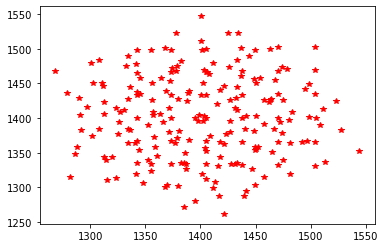

In [6]:
%matplotlib inline

for i in range(len(X_cs2)):
    plt.plot(X_cs2[i][:, 0], X_cs2[i][:, 1], 'r*', label='Ground truth')
    # break

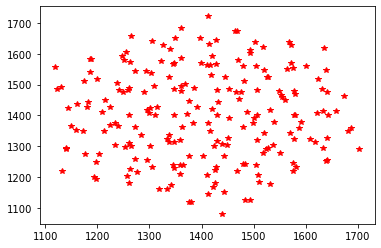

In [7]:
%matplotlib inline

for i in range(len(X_cs1)):
    plt.plot(X_cs1[i][:, 0], X_cs1[i][:, 1], 'r*', label='Ground truth')
    # break

In [8]:
import cv2

X_ws = X_ws1.copy()
X_cs = X_cs1.copy()
Rs = Rs1.copy()

N_OK = len(X_cs)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

cvX_ws = X_ws.copy()
cvX_cs = X_cs.copy()
for i in range(len(X_ws)):
    n_points = X_ws[0].shape[0]
    cvX_ws[i] = X_ws[i].reshape(1, n_points, 3)
    cvX_cs[i] = X_cs[i].reshape(n_points, 1, 2)

# https://docs.opencv.org/master/db/d58/group__calib3d__fisheye.html#gad626a78de2b1dae7489e152a5a5a89e1
retval, K, D, rvecs, tvecs = \
    cv2.fisheye.calibrate(
        cvX_ws,
        cvX_cs,
        (2300, 2300),
        K,
        D,
        rvecs,
        tvecs,
        cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_K2 + cv2.fisheye.CALIB_FIX_K3 + cv2.fisheye.CALIB_FIX_K4 ,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-9)
    )

print('R = %s' % Rs)
print('retval = %s' % retval)
print('K = %s' % K)
print('D = %s' % D)
print('rvecs = %s' % rvecs)
print('tvecs = %s' % tvecs)

R = [[-0.         -0.28559933  1.57079633]
 [-0.25594299 -0.12814321  0.45428531]
 [-0.23308132  0.16656911 -0.60965865]
 [ 0.04628523  0.28192503 -1.73577287]
 [ 0.27246669  0.08669423 -2.84109524]
 [ 0.20427571 -0.20100617  2.37465258]]
retval = 8.049421211573198e-12
K = [[8.0e+02 0.0e+00 1.4e+03]
 [0.0e+00 8.0e+02 1.4e+03]
 [0.0e+00 0.0e+00 1.0e+00]]
D = [[-1.39242534e-12]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
rvecs = [array([[-0.22417145],
       [-0.22417145],
       [ 1.55914667]]), array([[-0.28029027],
       [-0.06722615],
       [ 0.46756811]]), array([[-0.27608904],
       [ 0.08984188],
       [-0.62486398]]), array([[-0.21045462],
       [ 0.2467422 ],
       [-1.71612967]]), array([[-0.06346216],
       [ 0.40299264],
       [-2.8028754 ]]), array([[-0.13945484],
       [-0.33562296],
       [ 2.33430899]])]
tvecs = [array([[-1.12693023e+00],
       [ 1.93397817e-12],
       [ 3.83797189e+00]]), array([[-0.51117118],
       [ 1.00432851],
       [ 3.83

In [9]:
%autoreload

res1 = optimize(X_ws1, X_cs1, maxiter=50)
res2 = optimize(X_ws2, X_cs2, maxiter=50, R=[np.pi,0.1,0.1])

In [10]:
print(res1)
print(Rs1)

K = [[8.09570080e+02 0.00000000e+00 1.40003010e+03]
 [0.00000000e+00 8.09570080e+02 1.39995268e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
D = [-0.23679241  2.39309089 -4.37493125  0.        ]
time = 11.9
jacobian = [[ 3.22680664e+01  2.94295986e+00  4.49407171e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.00360565e+01 -1.82736348e+00 -2.79046655e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.57129669e+01  2.03740775e+00  2.28519215e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.16467285e+00  1.41933868e-01  1.16177885e-02 ... -1.13701019e+02
  -1.86774445e+01 -5.57275033e+01]
 [-3.99672546e+01 -3.77899880e+00 -6.37482112e-01 ...  7.12851868e+01
   9.91809235e+01 -2.44333130e+02]
 [ 1.25415039e+01  1.18582367e+00  2.00038020e-01 ... -1.28880142e+02
  -4.11944122e+01 -1.10574292e+02]]
R = [array([ 1.19081894e-04, -2.86466974e-01,  1.57080954e+00]), array([-0.25660859, -0.12879913,  0.45413667]), array([-0.23348556,  0.16

In [11]:
print(res2)
print(Rs2)

K = [[7.99999976e+02 0.00000000e+00 1.40000000e+03]
 [0.00000000e+00 7.99999976e+02 1.40000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
D = [ 2.24412561e-06 -1.40143856e-04  2.45485654e-03  0.00000000e+00]
time = 11.4
jacobian = [[-6.86492920e-01 -8.13293457e-03 -1.06811523e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.73193359e-01 -9.17053223e-03 -1.06811523e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.00543213e-01 -2.77709961e-03 -1.52587891e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 3.00735474e+00  7.37152100e-02  1.81579590e-03 ... -5.17596265e+02
   5.76544189e+00  2.46885160e+01]
 [ 2.87780762e-02  9.61303711e-04  3.05175781e-05 ... -1.48529867e-01
  -5.27425140e+02  9.46289040e+01]
 [ 4.93568420e+00  1.66030884e-01  5.58471680e-03 ... -5.22296961e+02
   1.22834778e+00  4.98166202e+01]]
R = [array([ 3.14159266, -0.28559934, -1.57079633]), array([ 3.39753565, -0.12814321, -0.45428531]), array([3.37467397, 0.

$$ \Delta R = R_{c1}^{w1} R_{c1}^{c2} (R_{c2}^{w2})^T (R_{w2}^{w1}) $$

In [12]:
for est, ref in zip(res1.R, Rs1):
    print(est, ref)
print('---')
for est, ref in zip(res2.R, Rs2):
    print(est, ref)

[ 1.19081894e-04 -2.86466974e-01  1.57080954e+00] [[-0.         -0.28559933  1.57079633]]
[-0.25660859 -0.12879913  0.45413667] [[-0.25594299 -0.12814321  0.45428531]]
[-0.23348556  0.16677377 -0.60963011] [[-0.23308132  0.16656911 -0.60965865]]
[ 0.04610509  0.28260154 -1.73579481] [[ 0.04628523  0.28192503 -1.73577287]]
[-2.86854263 -3.22853497  0.30042617] [[ 0.27246669  0.08669423 -2.84109524]]
[ 0.20478302 -0.2013803   2.37473264] [[ 0.20427571 -0.20100617  2.37465258]]
---
[ 3.14159266 -0.28559934 -1.57079633] [[-3.14159265 -0.28559933 -1.57079633]]
[ 3.39753565 -0.12814321 -0.45428531] [[-2.88564966 -0.12814321 -0.45428531]]
[3.37467397 0.1665691  0.60965865] [[-2.90851134  0.16656911  0.60965865]]
[3.09530742 0.28192503 1.73577287] [[3.09530742 0.28192503 1.73577287]]
[2.86912597 0.08669423 2.84109524] [[2.86912597 0.08669423 2.84109524]]
[ 2.93731694 -0.20100618 -2.37465258] [[ 2.93731694 -0.20100617 -2.37465258]]


In [13]:
from scipy.optimize import least_squares


def ls_func(params, Rcws1, Rcws2):
    Rcc = params[0:3]
    Rww = params[3:6]
    # Rww = [0,0,0]
    
    resid = []
    for Rcw1, Rcw2 in zip(Rcws1, Rcws2):
        if type(Rcw1) == np.matrix:
            Rcw1 = Rcw1.A1
        if type(Rcw2) == np.matrix:
            Rcw2 = Rcw2.A1
            
        r = get_angles(get_rotation(Rcw1) * get_rotation(Rcc) * get_rotation(Rcw2).T * get_rotation(Rww))
        
        for i in range(3):
            resid.append(r[i])
            
    lam = 10
    priors = lam * get_angles(get_rotation(Rww) * get_rotation([0, 0, 0]).T)
    for prior in priors:
        resid.append(prior)
            
    return resid


x0 = [0, 0, 5 ] + [0,0,0]
# x_scale='jac', tr_solver='exact', jac='3-point', xtol=1e-10, ftol=1e-10, diff_step=[1e-10]*6
# args=(res1.R, res2.R)
# args=(Rs1, Rs2)
res = least_squares(ls_func, np.array(x0), args=(res1.R, res2.R), tr_solver='lsmr', x_scale='jac', xtol=1e-10, ftol=1e-10, gtol=1e-10)

print(res.message)
print(res.x)
x = res.x
jacobian = res.jac

print(np.round(ls_func(x, res1.R, res2.R), 4) / np.pi * 180)

`gtol` termination condition is satisfied.
[-2.56971463e+00 -1.47198091e-04  6.28323307e+00  1.60296178e-06
  5.75189208e-06  6.94454760e-14]
[-0.         -0.01145916  0.         -0.00572958 -0.01145916  0.
  0.01145916 -0.00572958 -0.         -0.00572958 -0.          0.
 -0.         -0.00572958 -0.         -0.00572958 -0.         -0.
  0.          0.00572958  0.        ]


(matrix([[ 1.00000000e+00,  7.03905017e-06,  1.66720582e-04,
           4.56785993e-03, -1.10609624e-02, -3.25613803e-06],
         [ 7.03905017e-06,  1.00000000e+00,  1.57408189e-02,
          -1.05813721e-02, -4.37247168e-03,  6.88411552e-02],
         [ 1.66720582e-04,  1.57408189e-02,  1.00000000e+00,
           3.05549895e-03,  1.25111360e-03,  2.28793556e-01],
         [ 4.56785993e-03, -1.05813721e-02,  3.05549895e-03,
           1.00000000e+00,  5.02325318e-11, -3.34136471e-07],
         [-1.10609624e-02, -4.37247168e-03,  1.25111360e-03,
           5.02325319e-11,  1.00000000e+00,  9.30800749e-08],
         [-3.25613803e-06,  6.88411552e-02,  2.28793556e-01,
          -3.34136471e-07,  9.30800749e-08,  1.00000000e+00]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae5743a080>)

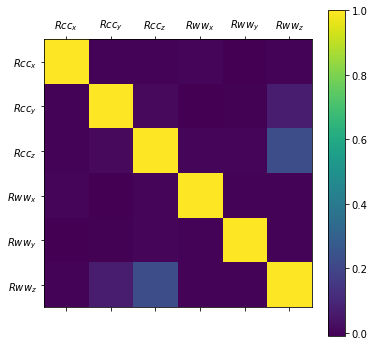

In [14]:
%autoreload

# show_correlation_matrix(jacobian, names=['$ Rcc_x $', '$ Rcc_y $', '$ Rcc_z $'])
show_correlation_matrix(jacobian, names=['$ Rcc_x $', '$ Rcc_y $', '$ Rcc_z $', '$ Rww_x $', '$ Rww_y $', '$ Rww_z $'])

$$
(J^T J)^{-1} J^T y \rightarrow (J^T \Sigma^{-1} J^T)^{-1}J^T \Sigma^{-1} y
$$

$$
\lambda * angle(R_{w2}^{w1} (\widetilde{R_{w2}^{w1}})^T) = 0
$$

In [15]:
def ls_func(params, Rcws1, Rcws2, Tcws1, Tcws2):
    Rcc = params[0:3]
    Rww = params[3:6]
    Tww = params[6:9]
    
    resid = []
    
    Tdiffs1 = []
    Tdiffs2 = []
    
    Tcw1_last = None
    Tcw2_last = None
    for Tcw1, Tcw2 in zip(Tcws1, Tcws2):
        if Tcw1_last is not None:
            Tdiffs1.append(Tcws1 - Tcw1_last)
            Tdiffs2.append(Tcws2 - Tcw2_last)
        Tcw2_last = Tcws2
    
    """
    for Po1, Po2 in zip(Ps1, Ps2):
        for P1, P2 in zip(Po1, Po2):
            r = get_rotation(Rww) * np.matrix(P1).T + np.matrix(Tww).T + np.matrix(P2).T
            # set_trace()
            for i in range(3):
                resid.append(r[i, 0])
    """
    
    for Rcw1, Rcw2 in zip(Rcws1, Rcws2):
        if type(Rcw1) == np.matrix:
            Rcw1 = Rcw1.A1
        if type(Rcw2) == np.matrix:
            Rcw2 = Rcw2.A1
            
        r = get_angles(get_rotation(Rcw1) * get_rotation(Rcc) * get_rotation(Rcw2).T * get_rotation(Rww))
        
        for i in range(3):
            resid.append(r[i])
            
    return resid

x0 = [0, 0, 5 ] + [ 0, 0, 0 ] + [ 0, 0, 0 ]
res = least_squares(ls_func, np.array(x0), args=(res1.R, res2.R, res1.T, res2.T), tr_solver='lsmr', xtol=1e-10, ftol=1e-10, gtol=1e-10)
jacobian = res.jac

In [16]:
print(np.round(res.x, 4))
print(R12 + [0, 0, 0] + [0, 0, 0.5])

[-2.5766e+00 -6.3400e-02  6.0659e+00  1.0000e-04  1.0000e-04 -2.2630e-01
  0.0000e+00  0.0000e+00  0.0000e+00]
[3.7127913178788465, 0, 0, 0, 0, 0, 0, 0, 0.5]


In [17]:
%autoreload
show_correlation_matrix(
    jacobian, 
    figsize=(10, 10), 
    names=['$ Rcc_x $', '$ Rcc_y $', '$ Rcc_z $', '$ Rww_x $', '$ Rww_y $', '$ Rww_z $', '$ Tww_x $', '$ Tww_y $', '$ Tww_z $']
);

LinAlgError: Singular matrix